# Supplementary figures for trimester h2 drop

In [1]:
library(tidyverse)
library(data.table)
# library(VennDiagram)
# library(ggsignif)
# library(ggsci)
# library(ggpubr)
# library(patchwork)

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”
Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘hms’”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




**Load data**

In [2]:
exp <- fread("../data/genes.629.bed.gz", data.table = F)

In [3]:
tri1 <- read.table("../results/eur_trimester/sig_pheno_trimester1.txt", header = T)
tri2 <- read.table("../results/eur_trimester/sig_pheno_trimester2.txt", header = T)

In [4]:
meta <- read.table("../metadata_654.tsv", header = T)

In [5]:
meta <- meta %>% filter(ancestry == "eur")
meta <- meta %>% arrange(Age)
meta <- meta %>% filter(Subject %in% colnames(exp))

In [9]:
dim(meta)

[1] 280   7

In [6]:
tri1_h2 <- fread("/u/project/gandalm/danieldu/gcta/data/sliding_fetal/hg19_gene_regressed/results/1Mbase_window/1_to_137_1Mbase_window.csv", data.table = F)
tri2_h2 <- fread("/u/project/gandalm/danieldu/gcta/data/sliding_fetal/hg19_gene_regressed/results/1Mbase_window/138_to_280_1Mbase_window.csv", data.table = F)

- 1: mean gene expression. Combat, normalized, no covariates
- 2: cis h2
- 3: phenovar

In [7]:
tri1_egene <- tri1 %>% filter(!pid %in% tri2$pid)
tri2_egene <- tri2 %>% filter(!pid %in% tri1$pid)
shared_egene <- tri1 %>% inner_join(tri2, by = "pid")

In [6]:
dim(tri1_egene)
dim(tri2_egene)
dim(shared_egene)

[1] 2950   13

[1] 959  13

[1] 1261   25

In [8]:
exp_df <- exp %>% select(ID, meta$Subject)
dim(exp_df)

[1] 31947   281

In [9]:
exp_1 <- exp_df %>% select(ID, meta[meta$trimester == "1","Subject"])
exp_2 <- exp_df %>% select(ID, meta[meta$trimester == "2","Subject"])

In [10]:
exp_1$row_mean <- apply(exp_1[,-1], 1, mean)
exp_2$row_mean <- apply(exp_2[,-1], 1, mean)

### 1: all expressed genes

`geom_smooth()` using formula 'y ~ x'



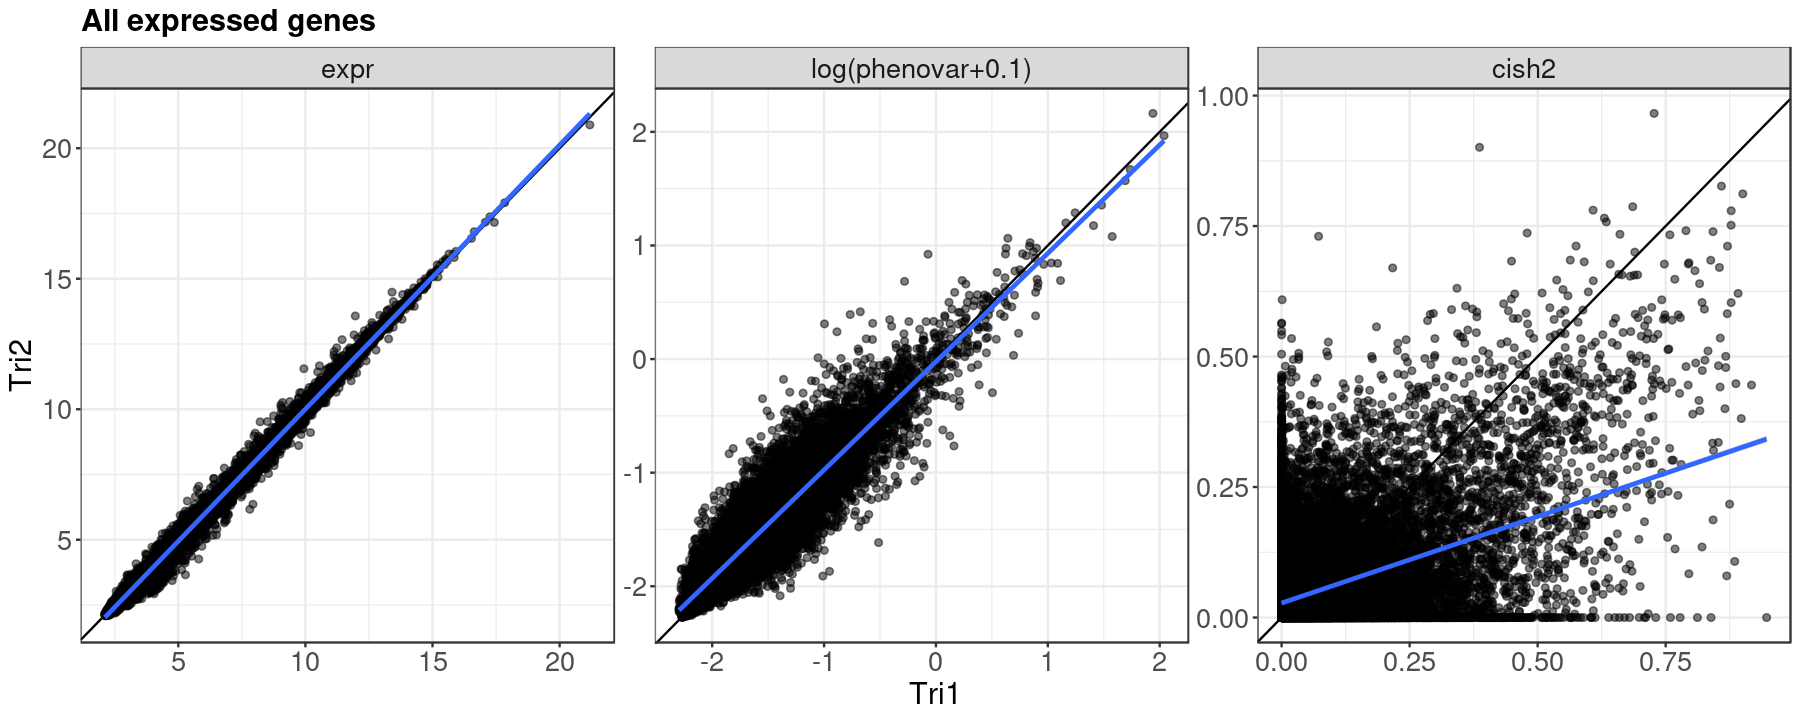

In [41]:
df_1 <- exp_1 %>% select(row_mean)
df_2 <- exp_2 %>% select(row_mean)
df_expr <- cbind(df_1, df_2)
colnames(df_expr) <- c("tri1", "tri2")
df_expr$Group <- "expr"

h2 <- tri1_h2 %>% inner_join(tri2_h2, by = "gene")
df.pheno.var <- data.frame("tri1" = h2$phenovar.x, "tri2" = h2$phenovar.y, "Group" = "phenovar")
df.cis.h2 <- data.frame("tri1" = h2$cish2.x, "tri2" = h2$cish2.y, "Group" = "cish2")

df.pheno.var.log <- df.pheno.var
df.pheno.var.log$tri1 <- log(df.pheno.var.log$tri1+0.1)
df.pheno.var.log$tri2 <- log(df.pheno.var.log$tri2+0.1)
df.pheno.var.log$Group <- "log(phenovar+0.1)"

df <- rbind(df_expr, df.pheno.var.log, df.cis.h2)
df$Group <- factor(df$Group, levels = c("expr", "log(phenovar+0.1)", "cish2"))

ggplot(df, aes(x = tri1, y = tri2)) +
    geom_point(alpha = 0.5) +
    facet_wrap(~Group, scales = "free") +
    geom_abline(intercept = 0, slope = 1) +
    geom_smooth(method = "lm", fullrange = TRUE) +
    labs(x = "Tri1", y = "Tri2", title = "All expressed genes") +
#     scale_x_continuous(limit = c(0, 6)) +
#     scale_y_continuous(limit = c(0, 6)) +
    theme_bw() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          strip.text.x = element_text(size = 16),
          plot.title = element_text(size = 18, face = "bold"))

In [42]:
ggsave("../figures/all_genes_h2.png", height = 6, width = 15)

`geom_smooth()` using formula 'y ~ x'



### 2: tri1 egene

In [28]:
df_1 <- exp_1 %>% filter(ID %in% tri1_egene$pid) %>% select(row_mean)
df_2 <- exp_2 %>% filter(ID %in% tri1_egene$pid) %>% select(row_mean)
df_expr <- cbind(df_1, df_2)
colnames(df_expr) <- c("tri1", "tri2")
df_expr$Group <- "expr"

In [29]:
h2_1 <- tri1_h2 %>% filter(gene %in% tri1_egene$pid)
h2_2 <- tri2_h2 %>% filter(gene %in% tri1_egene$pid)
df.pheno.var <- data.frame("tri1" = h2_1$phenovar, "tri2" = h2_2$phenovar, "Group" = "phenovar")
df.cis.h2 <- data.frame("tri1" = h2_1$cish2, "tri2" = h2_2$cish2, "Group" = "cish2")

In [30]:
df <- rbind(df_expr, df.pheno.var, df.cis.h2)
df$Group <- factor(df$Group, levels = c("expr", "phenovar", "cish2"))

`geom_smooth()` using formula 'y ~ x'



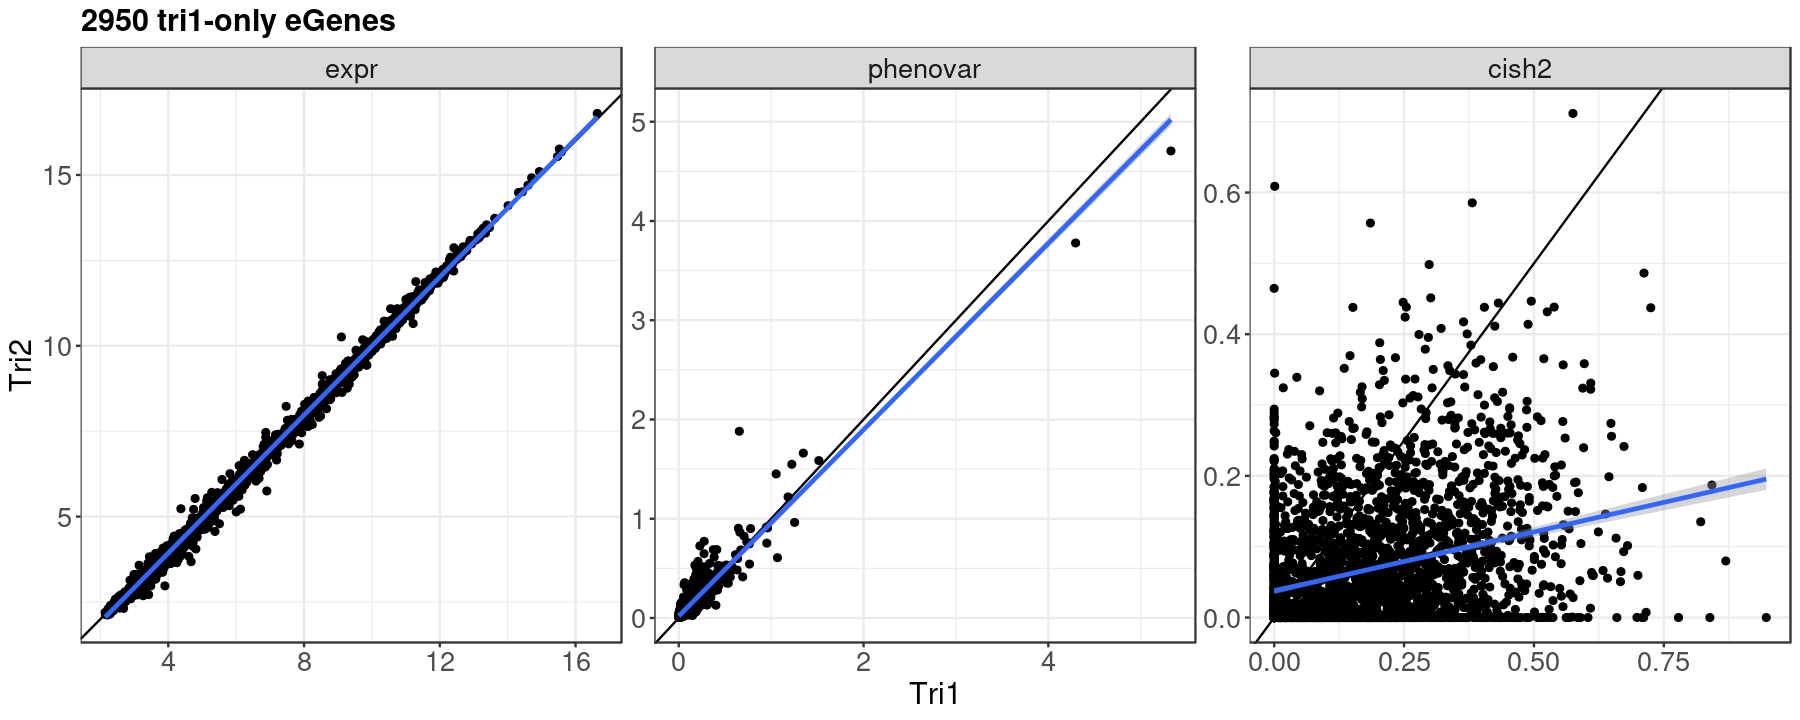

In [14]:
options(repr.plot.width = 15, repr.plot.height = 6)

ggplot(df, aes(x = tri1, y = tri2)) +
    geom_point() +
    facet_wrap(~Group, scales = "free") +
    geom_abline(intercept = 0, slope = 1) +
    geom_smooth(method = "lm", fullrange = TRUE) +
    labs(x = "Tri1", y = "Tri2", title = "2950 tri1-only eGenes") +
#     scale_x_continuous(limit = c(0, 6)) +
#     scale_y_continuous(limit = c(0, 6)) +
    theme_bw() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          strip.text.x = element_text(size = 16),
          plot.title = element_text(size = 18, face = "bold"))

`geom_smooth()` using formula 'y ~ x'



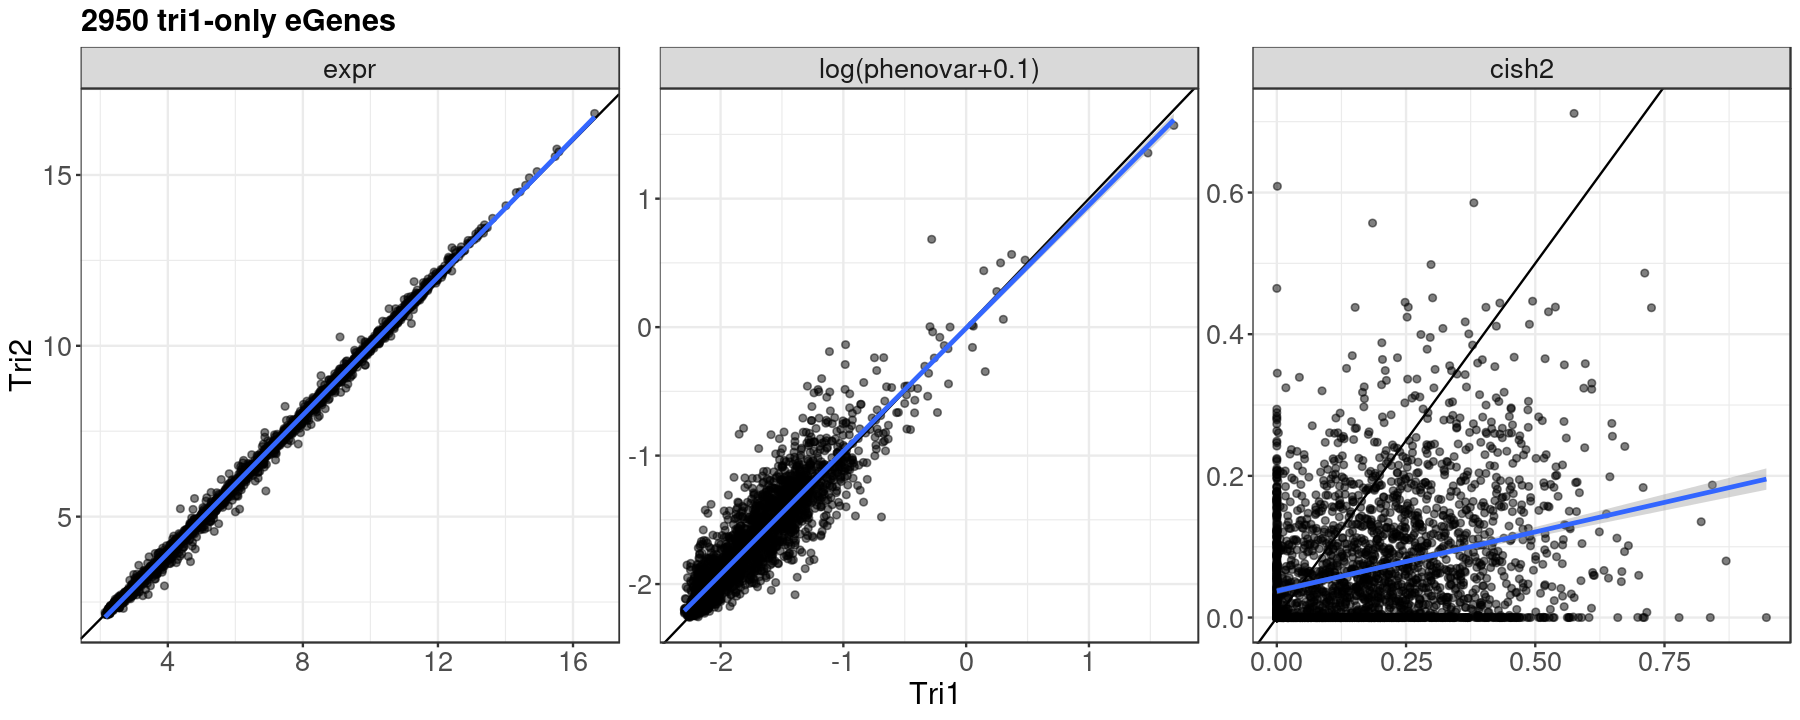

In [31]:
df.pheno.var.log <- df.pheno.var
df.pheno.var.log$tri1 <- log(df.pheno.var.log$tri1+0.1)
df.pheno.var.log$tri2 <- log(df.pheno.var.log$tri2+0.1)
df.pheno.var.log$Group <- "log(phenovar+0.1)"

df <- rbind(df_expr, df.pheno.var.log, df.cis.h2)
df$Group <- factor(df$Group, levels = c("expr", "log(phenovar+0.1)", "cish2"))

ggplot(df, aes(x = tri1, y = tri2)) +
    geom_point(alpha = 0.5) +
    facet_wrap(~Group, scales = "free") +
    geom_abline(intercept = 0, slope = 1) +
    geom_smooth(method = "lm", fullrange = TRUE) +
    labs(x = "Tri1", y = "Tri2", title = "2950 tri1-only eGenes") +
#     scale_x_continuous(limit = c(0, 6)) +
#     scale_y_continuous(limit = c(0, 6)) +
    theme_bw() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          strip.text.x = element_text(size = 16),
          plot.title = element_text(size = 18, face = "bold"))

In [32]:
ggsave("../figures/tri1_egenes_h2.png", height = 6, width = 15)

`geom_smooth()` using formula 'y ~ x'



### 3: tri2 egene

`geom_smooth()` using formula 'y ~ x'



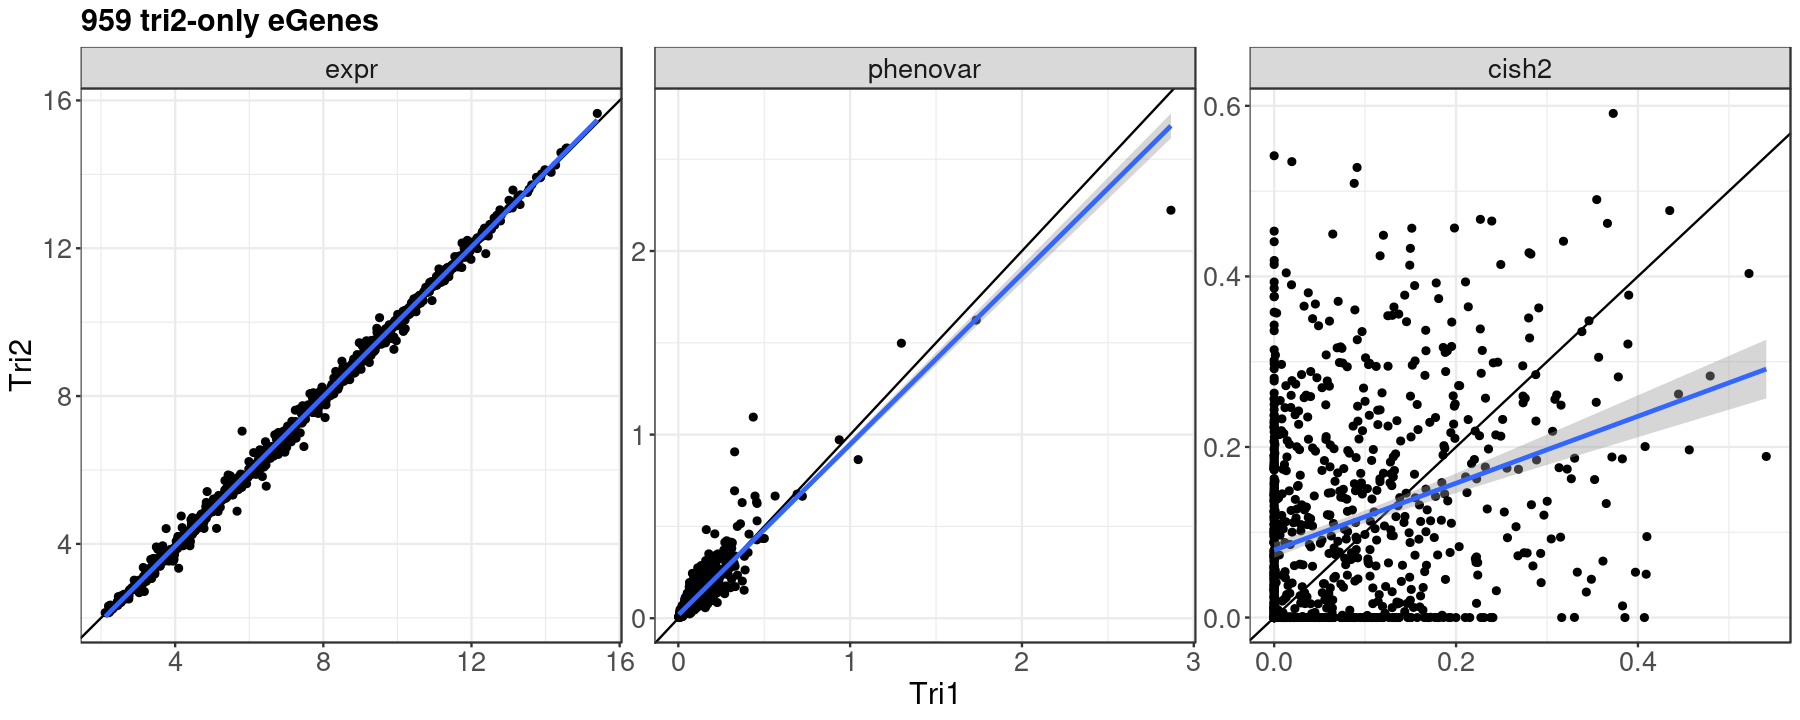

In [33]:
df_1 <- exp_1 %>% filter(ID %in% tri2_egene$pid) %>% select(row_mean)
df_2 <- exp_2 %>% filter(ID %in% tri2_egene$pid) %>% select(row_mean)
df_expr <- cbind(df_1, df_2)
colnames(df_expr) <- c("tri1", "tri2")
df_expr$Group <- "expr"

h2_1 <- tri1_h2 %>% filter(gene %in% tri2_egene$pid)
h2_2 <- tri2_h2 %>% filter(gene %in% tri2_egene$pid)
df.pheno.var <- data.frame("tri1" = h2_1$phenovar, "tri2" = h2_2$phenovar, "Group" = "phenovar")
df.cis.h2 <- data.frame("tri1" = h2_1$cish2, "tri2" = h2_2$cish2, "Group" = "cish2")

df <- rbind(df_expr, df.pheno.var, df.cis.h2)
df$Group <- factor(df$Group, levels = c("expr", "phenovar", "cish2"))

options(repr.plot.width = 15, repr.plot.height = 6)

ggplot(df, aes(x = tri1, y = tri2)) +
    geom_point() +
    facet_wrap(~Group, scales = "free") +
    geom_abline(intercept = 0, slope = 1) +
    geom_smooth(method = "lm", fullrange = TRUE) +
    labs(x = "Tri1", y = "Tri2", title = "959 tri2-only eGenes") +
#     scale_x_continuous(limit = c(0, 6)) +
#     scale_y_continuous(limit = c(0, 6)) +
    theme_bw() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          strip.text.x = element_text(size = 16),
          plot.title = element_text(size = 18, face = "bold"))

# ggsave("../figures/tri2_egenes_h2.pdf", height = 6, width = 15)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



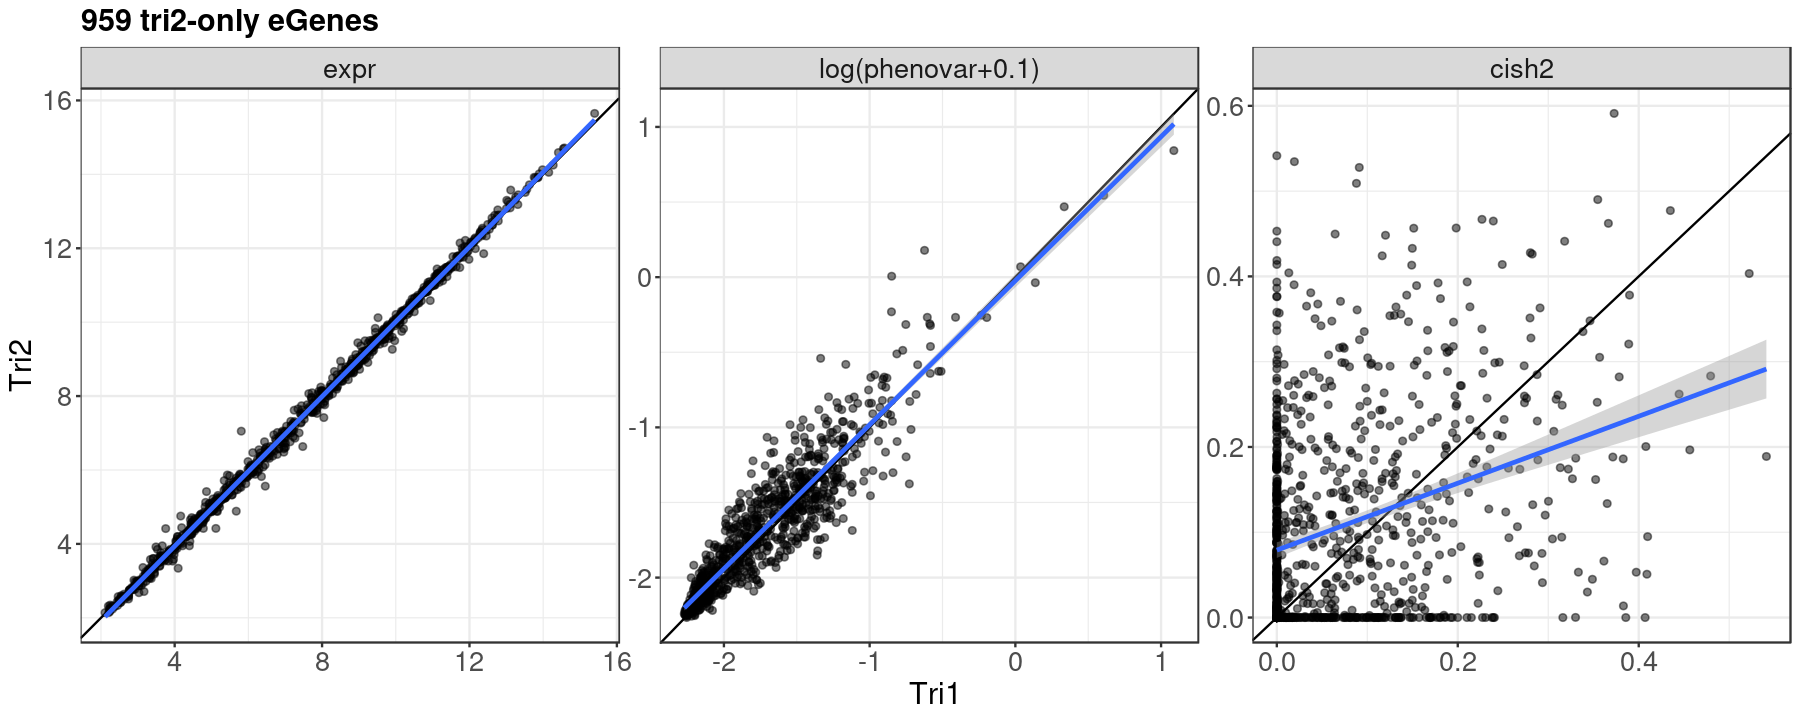

In [34]:
df.pheno.var.log <- df.pheno.var
df.pheno.var.log$tri1 <- log(df.pheno.var.log$tri1+0.1)
df.pheno.var.log$tri2 <- log(df.pheno.var.log$tri2+0.1)
df.pheno.var.log$Group <- "log(phenovar+0.1)"

df <- rbind(df_expr, df.pheno.var.log, df.cis.h2)
df$Group <- factor(df$Group, levels = c("expr", "log(phenovar+0.1)", "cish2"))

ggplot(df, aes(x = tri1, y = tri2)) +
    geom_point(alpha = 0.5) +
    facet_wrap(~Group, scales = "free") +
    geom_abline(intercept = 0, slope = 1) +
    geom_smooth(method = "lm", fullrange = TRUE) +
    labs(x = "Tri1", y = "Tri2", title = "959 tri2-only eGenes") +
#     scale_x_continuous(limit = c(0, 6)) +
#     scale_y_continuous(limit = c(0, 6)) +
    theme_bw() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          strip.text.x = element_text(size = 16),
          plot.title = element_text(size = 18, face = "bold"))

ggsave("../figures/tri2_egenes_h2.png", height = 6, width = 15)

### 4: shared egene

`geom_smooth()` using formula 'y ~ x'



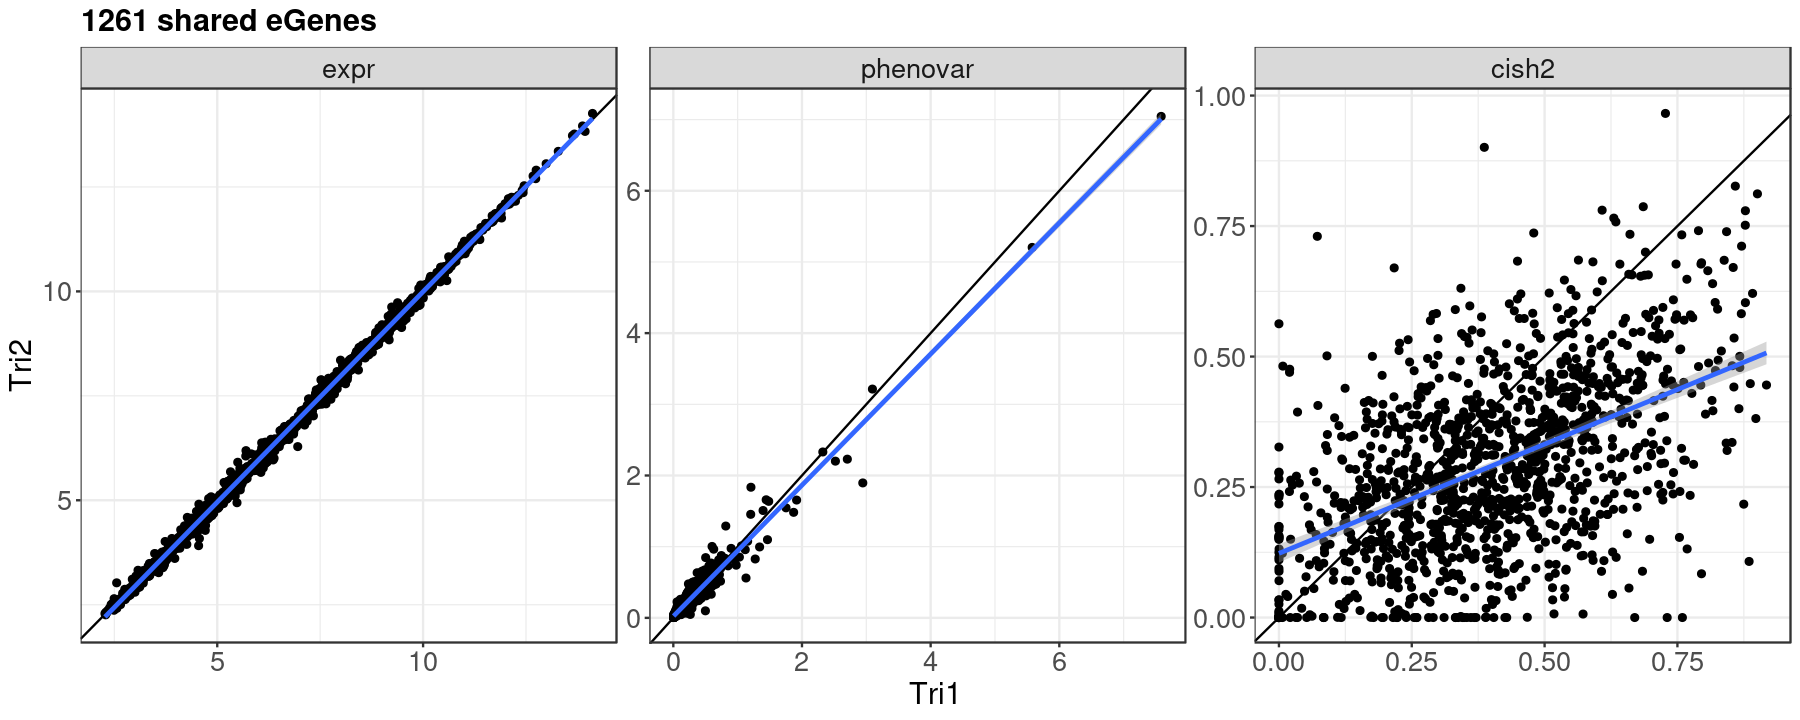

In [35]:
df_1 <- exp_1 %>% filter(ID %in% shared_egene$pid) %>% select(row_mean)
df_2 <- exp_2 %>% filter(ID %in% shared_egene$pid) %>% select(row_mean)
df_expr <- cbind(df_1, df_2)
colnames(df_expr) <- c("tri1", "tri2")
df_expr$Group <- "expr"

h2_1 <- tri1_h2 %>% filter(gene %in% shared_egene$pid)
h2_2 <- tri2_h2 %>% filter(gene %in% shared_egene$pid)
df.pheno.var <- data.frame("tri1" = h2_1$phenovar, "tri2" = h2_2$phenovar, "Group" = "phenovar")
df.cis.h2 <- data.frame("tri1" = h2_1$cish2, "tri2" = h2_2$cish2, "Group" = "cish2")

df <- rbind(df_expr, df.pheno.var, df.cis.h2)
df$Group <- factor(df$Group, levels = c("expr", "phenovar", "cish2"))

options(repr.plot.width = 15, repr.plot.height = 6)

ggplot(df, aes(x = tri1, y = tri2)) +
    geom_point() +
    facet_wrap(~Group, scales = "free") +
    geom_abline(intercept = 0, slope = 1) +
    geom_smooth(method = "lm", fullrange = TRUE) +
    labs(x = "Tri1", y = "Tri2", title = "1261 shared eGenes") +
#     scale_x_continuous(limit = c(0, 6)) +
#     scale_y_continuous(limit = c(0, 6)) +
    theme_bw() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          strip.text.x = element_text(size = 16),
          plot.title = element_text(size = 18, face = "bold"))

# ggsave("../figures/shared_egenes_h2.pdf", height = 6, width = 15)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



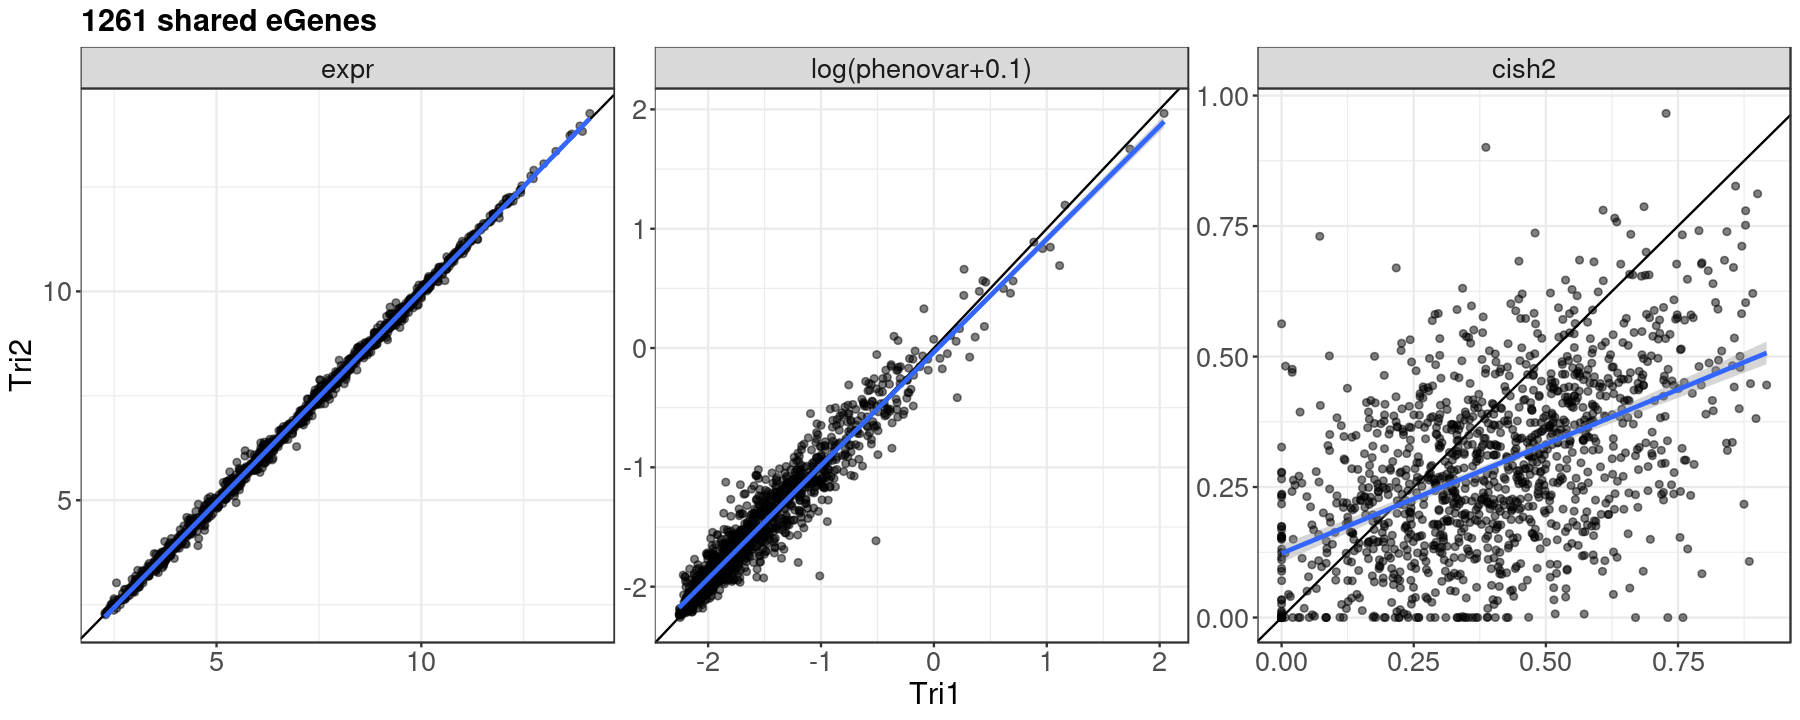

In [36]:
df.pheno.var.log <- df.pheno.var
df.pheno.var.log$tri1 <- log(df.pheno.var.log$tri1+0.1)
df.pheno.var.log$tri2 <- log(df.pheno.var.log$tri2+0.1)
df.pheno.var.log$Group <- "log(phenovar+0.1)"

df <- rbind(df_expr, df.pheno.var.log, df.cis.h2)
df$Group <- factor(df$Group, levels = c("expr", "log(phenovar+0.1)", "cish2"))

ggplot(df, aes(x = tri1, y = tri2)) +
    geom_point(alpha = 0.5) +
    facet_wrap(~Group, scales = "free") +
    geom_abline(intercept = 0, slope = 1) +
    geom_smooth(method = "lm", fullrange = TRUE) +
    labs(x = "Tri1", y = "Tri2", title = "1261 shared eGenes") +
#     scale_x_continuous(limit = c(0, 6)) +
#     scale_y_continuous(limit = c(0, 6)) +
    theme_bw() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          strip.text.x = element_text(size = 16),
          plot.title = element_text(size = 18, face = "bold"))

ggsave("../figures/shared_egenes_h2.png", height = 6, width = 15)